# Import

In [1]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

In [3]:
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [4]:
# convert from int to float
X_train = X_train/255.0
X_test = X_test/255.0

In [54]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1,1))
y_train_tran = enc.transform(y_train.reshape(-1,1))
y_train_tran = y_train_tran.toarray()

y_test_tran = enc.transform(y_test.reshape(-1,1))
y_test_tran = y_test_tran.toarray()

# Genarate Images

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0.

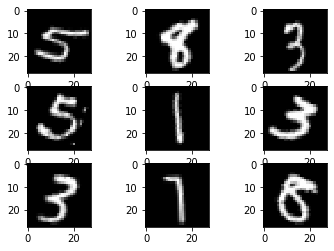

In [55]:
datagen = ImageDataGenerator(
                    # featurewise_center=True,
                    # featurewise_std_normalization=True,
                    horizontal_flip=False,
                    vertical_flip=False,
                    height_shift_range=1,
                    #zoom_range=[2, 2]
                    zoom_range=0.05,
                    rotation_range=30
                )
datagen.fit(X_train)
for X_batch, y_batch in datagen.flow(X_train, y_train_tran, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        print(y_batch)
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [168]:
import tensorflow as tf

from keras.layers import (Input, Concatenate, concatenate, Dropout,
                          BatchNormalization, Conv2D, Flatten, Dense, MaxPooling2D)

from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping

def getCheckPoint(filepath, monitor, verbose=1, mode='min'):
    return ModelCheckpoint(filepath,
                           monitor=monitor,
                           verbose=verbose,
                           save_best_only=True,
                           include_optimizer = False,
                           mode=mode)

def getEarlyStop(monitor, verbose=1, mode='min'):
    return EarlyStopping(monitor=monitor, mode = 'min', patience=5)

# Get get hyper param
early_stop = getEarlyStop('val_loss')
# checkpoint = getCheckPoint('Best_model_with_{val_loss:.5}.model', 'val_loss')

checkpoint = getCheckPoint('Best_model.model', 'val_loss')

InputLayer = Input(shape=X_train[0].shape)

# Shape: (28, 28, 1)
Filter_number = 32
Conv2D_layer = Conv2D(Filter_number, (3, 3), input_shape=X_train[0].shape)(InputLayer)
# Shape: (1, 28 -3 + 1, 28 -3 +1, Filter_number) = (1, 26, 26, 32)

Pool_size = (2, 2)
max_pooling_layer = MaxPooling2D((2, 2))(Conv2D_layer)
# Shape: ((1, 26/pool size[0], 26/pool size[1], 32))
# OutputLayer = Dense(1, activation='sigmoid')(Conv2D_layer)

flatten_layer = Flatten()(max_pooling_layer)

output_layer = Dense(100, activation='sigmoid')(flatten_layer)
for dense_out in [10]:
    output_layer = Dropout(0.4)(output_layer, training=True)
    output_layer = Dense(dense_out, activation='sigmoid')(output_layer)


model = Model(inputs=InputLayer, outputs=output_layer)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam')

# Visualise Cool things

In [11]:
import numpy as np
Conv_map = model.predict(np.array([X_batch[0]]))
# pyplot.imshow(Conv_map.reshape(28, 28), cmap=pyplot.get_cmap('gray'))

In [12]:
print(X_batch[0].shape)
print(Conv_map.shape)

(28, 28, 1)
(1, 26, 26, 32)


In [15]:
Conv_map[0,...,1].shape

(26, 26)

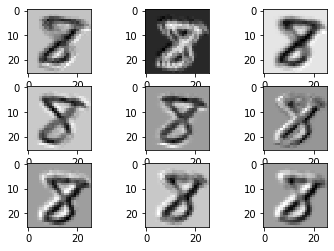

In [29]:
for filter_index in range(Conv_map.shape[-1]):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(Conv_map[0,...,i], cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

In [114]:
model = Model(inputs=InputLayer, outputs=MaxPooling)
Max_pooling = model.predict(np.array([X_batch[0]]))
Max_pooling.shape

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_6:0", shape=(None, 28, 28, 1), dtype=float32) at layer "conv2d_5". The following previous layers were accessed without issue: []

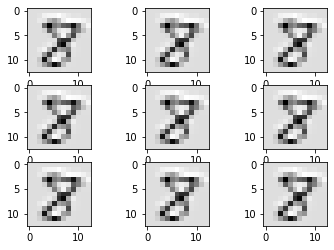

In [30]:
for filter_index in range(Conv_map.shape[-1]):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(Max_pooling[0,...,1], cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

In [147]:
Dense(10)(np.array([[2,2]]), training=True).numpy()

array([[ 1.0279223 ,  0.06736678, -0.33954   ,  0.08725607, -0.630563  ,
        -0.19077754,  0.23379755, -1.2674838 ,  1.6990244 ,  0.7083775 ]],
      dtype=float32)

In [153]:
dense_10 = Dense(10, activation='sigmoid')

In [160]:
print(dense_10(np.array([[2,2]])).numpy())
print(Dropout(0.5, input_shape=(1, 10))(dense_10(np.array([[2,2]])) ,training=True))

[[0.5028108  0.7527182  0.3043084  0.33464748 0.7868953  0.08150437
  0.0820531  0.49366808 0.3775915  0.12830102]]
tf.Tensor(
[[0.         0.         0.6086168  0.         1.5737906  0.
  0.16410619 0.98733616 0.755183   0.25660205]], shape=(1, 10), dtype=float32)


In [172]:
model = Model(inputs=InputLayer, outputs=output_layer)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

for i, (X_batch, Y_batch) in enumerate(datagen.flow(X_train, y_train_tran, batch_size=32)):
    # create a grid of 3x3 images
    print(f"Batch: {i}")
    model.fit(X_batch, Y_batch, validation_data=(X_test, y_test_tran), epochs=100)
    if i == 1:
        break


Batch: 0
Epoch 1/100
1/1 [==============================] - 1s 723ms/step - loss: 0.0469 - categorical_accuracy: 0.9375 - val_loss: 0.0209 - val_categorical_accuracy: 0.9728
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.0800 - categorical_accuracy: 0.9375

KeyboardInterrupt: 

In [95]:
X_test.shape

(10000, 28, 28, 1)

In [ ]:
def getCheckPoint(filepath, monitor, verbose=1, mode='min'):
    return ModelCheckpoint(filepath,
                           monitor=monitor,
                           verbose=verbose,
                           save_best_only=True,
                           include_optimizer = False,
                           mode=mode)

def getEarlyStop(monitor, verbose=1, mode='min'):
    return EarlyStopping(monitor=monitor, mode = 'min', patience=5)


# Get get hyper param
early_stop = getEarlyStop('val_categorical_accuracy')
# checkpoint = getCheckPoint('Best_model_with_{val_loss:.5}.model', 'val_loss')
checkpoint = getCheckPoint('Best_model.model', 'val_loss')

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.fit(datagen.flow(X_train, y_train_tran, batch_size=32),
          steps_per_epoch=len(X_train) / 32, epochs=200,
          validation_data=(X_test, y_test_tran), batch_size=32 )

callbacks = [checkpoint, early_stop],

In [82]:
sampling = -8
print(enc.inverse_transform(model.predict(X_test[sampling:sampling + 1])))
print(y_test[sampling])

[[9]]
9


In [74]:
enc.inverse_transform(model.predict(X_test[0:1]))

array([[7]], dtype=uint8)

In [101]:
model = Model(inputs=InputLayer, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.BinaryCrossentropy()
batch_size = int(500)

# # Set tensor dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train_precessed))
# # Set batch training
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_tran))
val_dataset = val_dataset.batch(len(X_test))

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)
    
# Looping

epochs =  200
# Prepare the metrics.
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    for step, (x_batch_train, y_batch_train) in enumerate(datagen.flow(
                    X_train,
                    y_train_tran,
                    batch_size=200)):
        
        loss_value = train_step(x_batch_train, y_batch_train)
        break
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * 64))
    print(f"Loss: {float(loss_value)}")
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)
        
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("="*36)


Start of epoch 0
Loss: 0.632456362247467
Training acc over epoch: 0.1200
Validation acc: 0.0892

Start of epoch 1
Loss: 0.33868956565856934
Training acc over epoch: 0.0825
Validation acc: 0.1751

Start of epoch 2
Loss: 0.32136863470077515
Training acc over epoch: 0.1000
Validation acc: 0.3790

Start of epoch 3
Loss: 0.3207792341709137
Training acc over epoch: 0.1737
Validation acc: 0.3431

Start of epoch 4
Loss: 0.321033239364624
Training acc over epoch: 0.2040
Validation acc: 0.3418

Start of epoch 5
Loss: 0.31488579511642456
Training acc over epoch: 0.2233
Validation acc: 0.3542

Start of epoch 6
Loss: 0.29303473234176636
Training acc over epoch: 0.2379
Validation acc: 0.3923

Start of epoch 7
Loss: 0.2824608087539673
Training acc over epoch: 0.2544
Validation acc: 0.4155

Start of epoch 8
Loss: 0.27031174302101135
Training acc over epoch: 0.2711
Validation acc: 0.5138

Start of epoch 9
Loss: 0.2641744315624237
Training acc over epoch: 0.2920
Validation acc: 0.5610

Start of epoch 1

KeyboardInterrupt: 